# Stochastic Test of PrivateClampedSum #

In [74]:
# Preamble: imports and figure settings

from eeprivacy.operations import (
    PrivateClampedSum,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from scipy import stats
from tqdm import tqdm

np.random.seed(1234) # Fix seed for deterministic documentation

mpl.style.use("seaborn-white")

MD = 28
LG = 14
plt.rcParams.update({
    "figure.figsize": [25, 10],
    "legend.fontsize": MD,
    "axes.labelsize": LG,
    "axes.titlesize": LG,
    "xtick.labelsize": LG,
    "ytick.labelsize": LG,
})

In [3]:
def run_stochastic_test(D, D_tilde, lower_bound, upper_bound, T=1000):
    op = PrivateClampedSum(lower_bound=lower_bound, upper_bound=upper_bound)
    epsilon = 1.0

    def run_trials(d, trials=1000):
        return [
            op.execute(values=d, epsilon=epsilon) for _ in tqdm(range(trials))
        ]

    trials = run_trials(D, trials=T)
    trials_tilde = run_trials(D_tilde, trials=T)

    print(f"Expected sum D {np.sum(D)} | Realized sum {np.mean(trials)}")
    print(f"Expected sum D_tilde {np.sum(D_tilde)} | Realized sum {np.mean(trials_tilde)}")

    bins = np.linspace(
      min(min(trials), min(trials_tilde)),
      max(max(trials), max(trials_tilde)),
      num=30
    )


    plt.hist(trials, bins=bins, alpha=0.5)
    plt.hist(trials_tilde, bins=bins, alpha=0.5)
    plt.show()

    h, _ = np.histogram(trials, bins)
    h_tilde, _ = np.histogram(trials_tilde, bins)
        
    epsilons = np.log(h / h_tilde)

    plt.plot(epsilons)
    plt.show()

100%|██████████| 10000/10000 [00:00<00:00, 23766.51it/s]
<ipython-input-3-9489309f86d5>:30: RuntimeWarning: divide by zero encountered in true_divide
  epsilons = np.log(h / h_tilde)
<ipython-input-3-9489309f86d5>:30: RuntimeWarning: invalid value encountered in true_divide
  epsilons = np.log(h / h_tilde)
<ipython-input-3-9489309f86d5>:30: RuntimeWarning: divide by zero encountered in log
  epsilons = np.log(h / h_tilde)


Expected sum D 0 | Realized sum -0.004711665122982089
Expected sum D_tilde 1 | Realized sum 1.0025292629897022


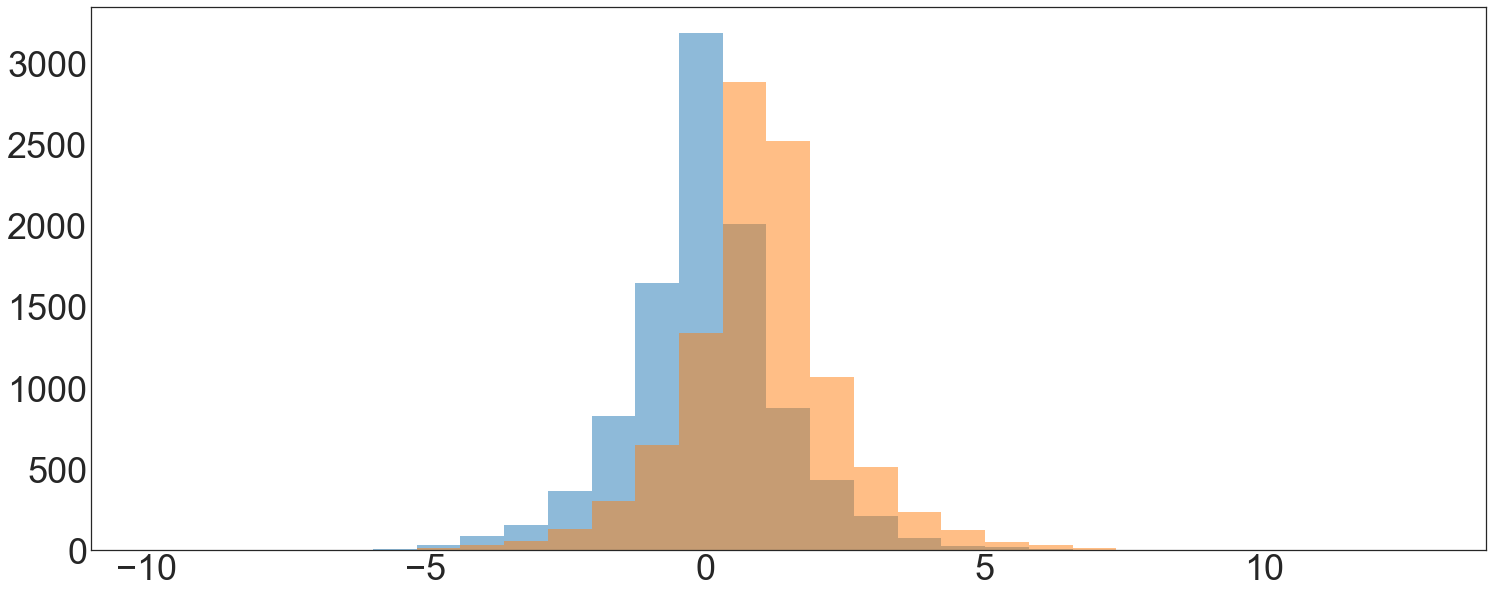

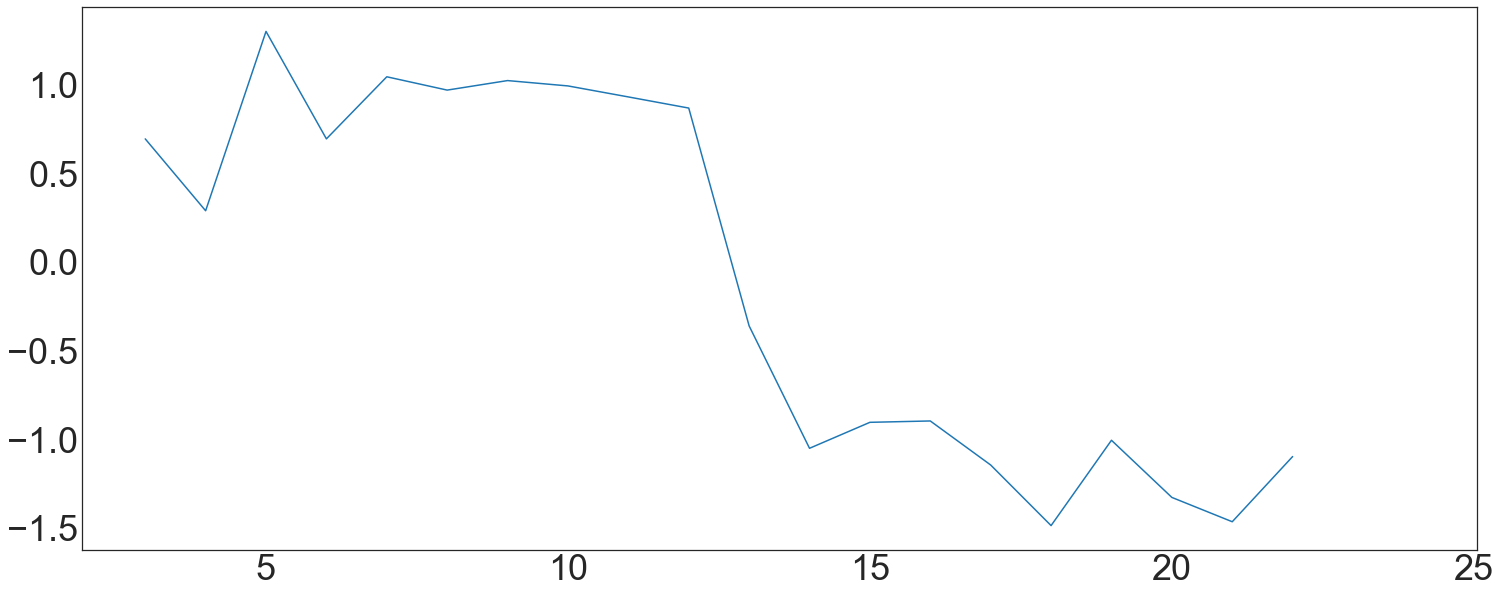

In [4]:
run_stochastic_test([0], [0, 1], lower_bound=0, upper_bound=1, T=10000)

100%|██████████| 100000/100000 [00:05<00:00, 18436.46it/s]
<ipython-input-3-9489309f86d5>:30: RuntimeWarning: divide by zero encountered in true_divide
  epsilons = np.log(h / h_tilde)
<ipython-input-3-9489309f86d5>:30: RuntimeWarning: invalid value encountered in true_divide
  epsilons = np.log(h / h_tilde)


Expected sum D 0 | Realized sum -0.0005259901582819642
Expected sum D_tilde 2 | Realized sum 0.9932399539877353


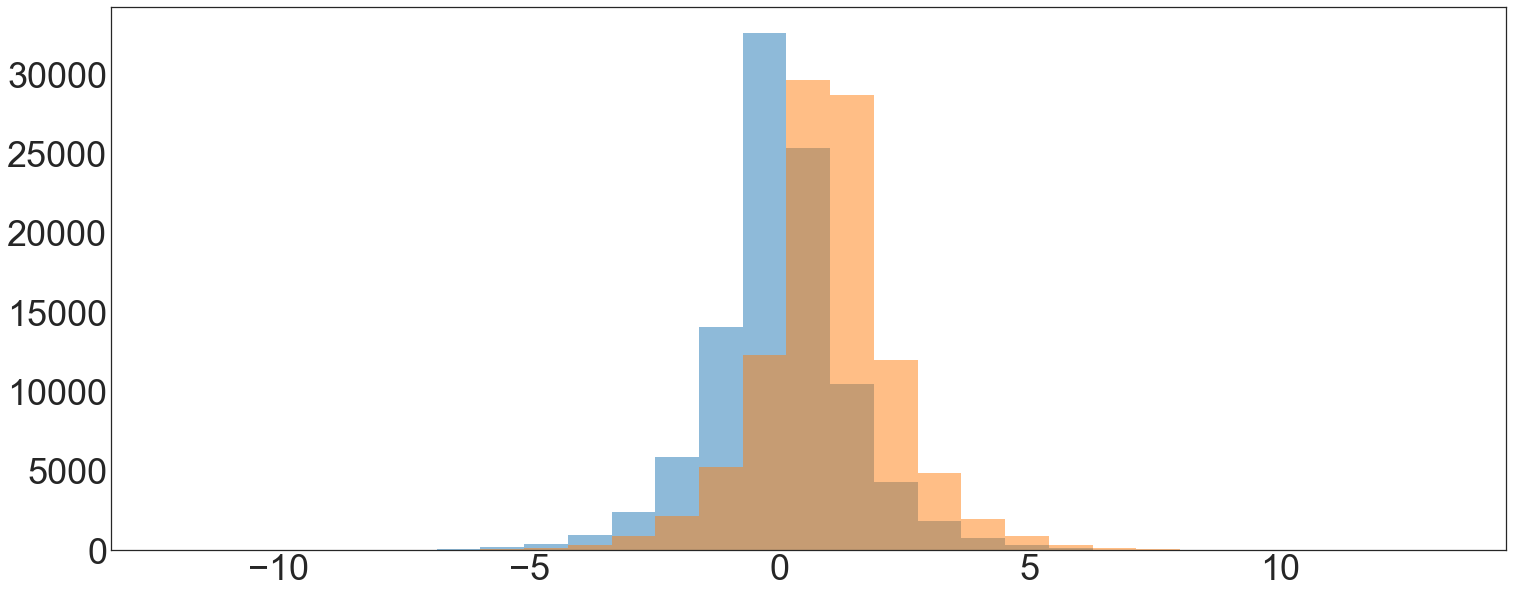

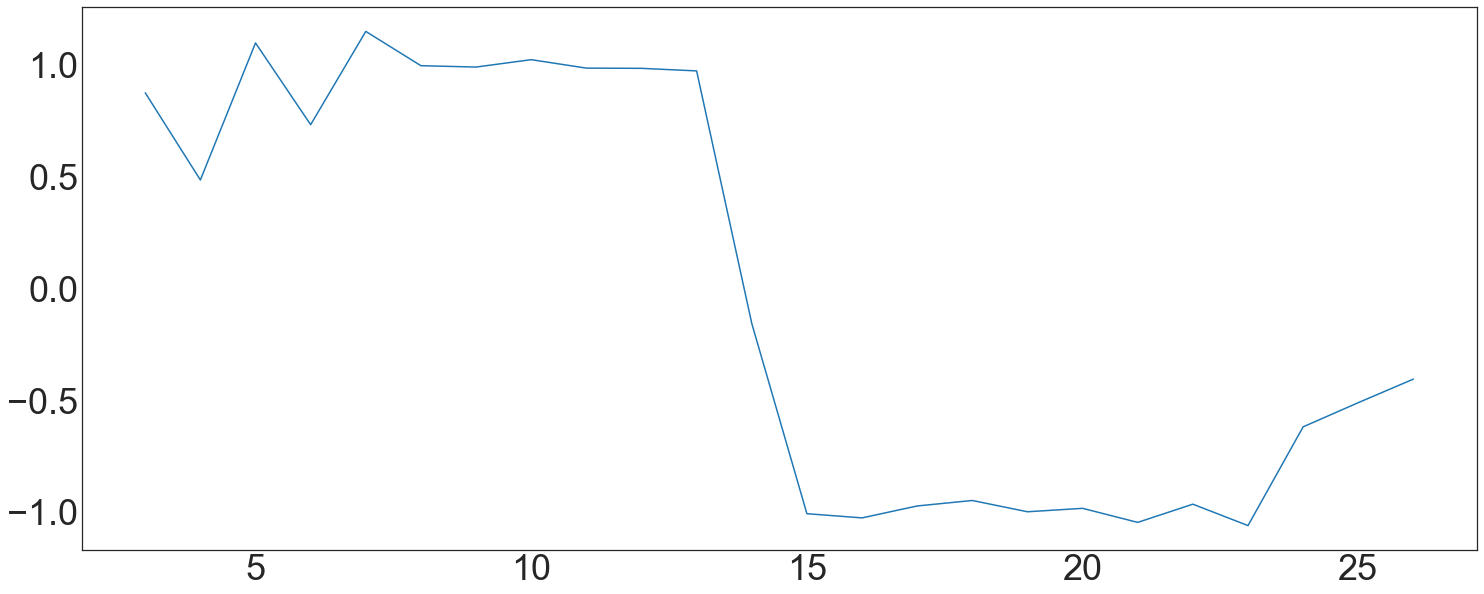

In [5]:
# This will fail is clamping is not being applied
run_stochastic_test([0], [0, 2], lower_bound=0, upper_bound=1, T=100000)

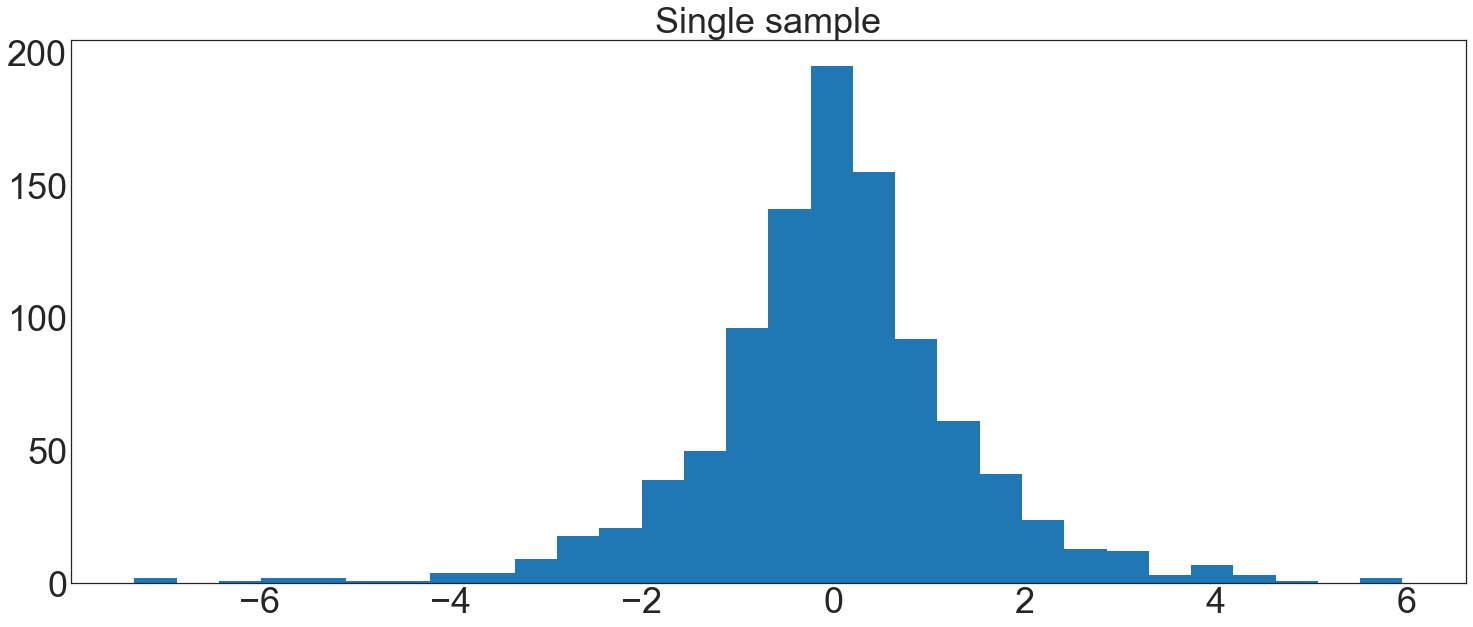

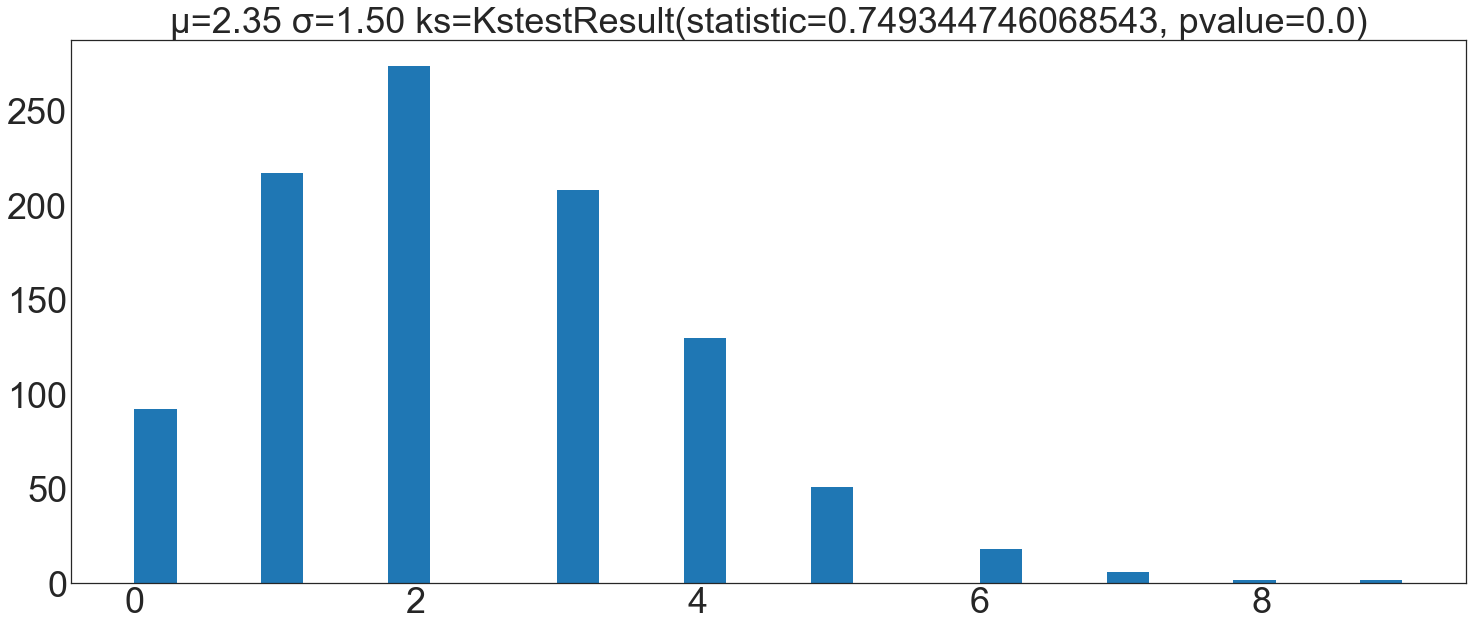

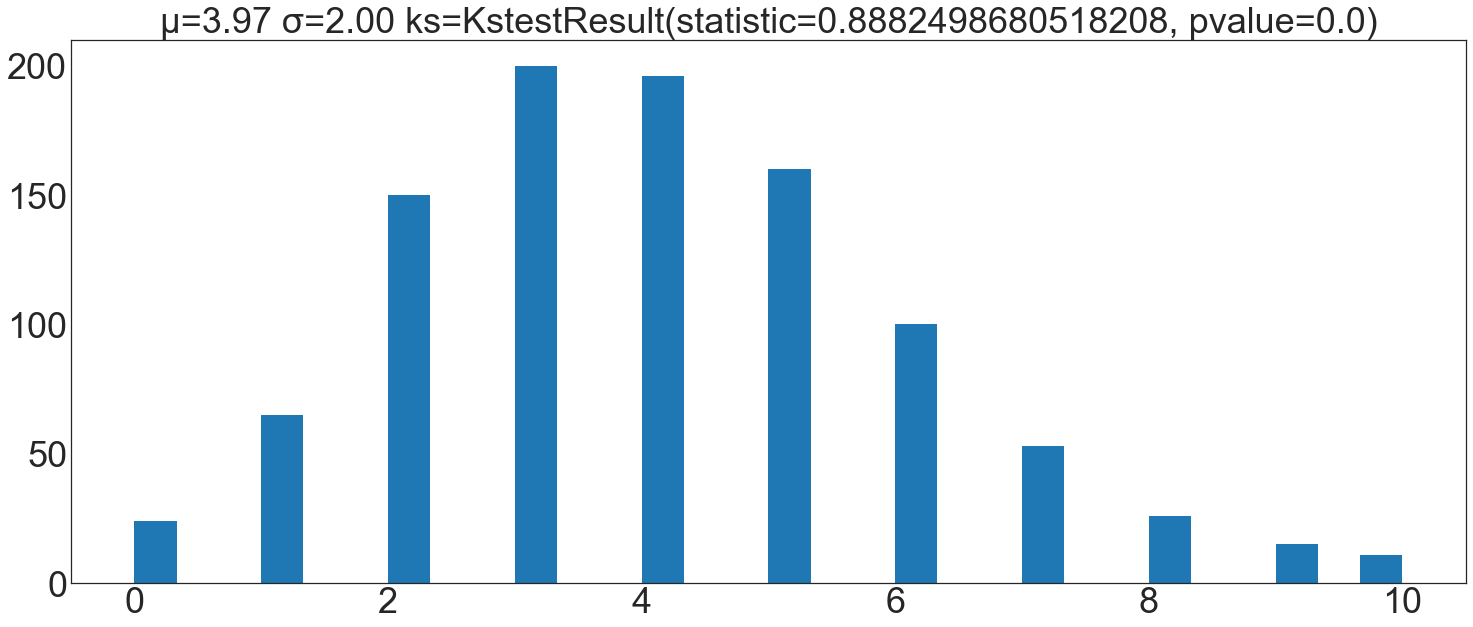

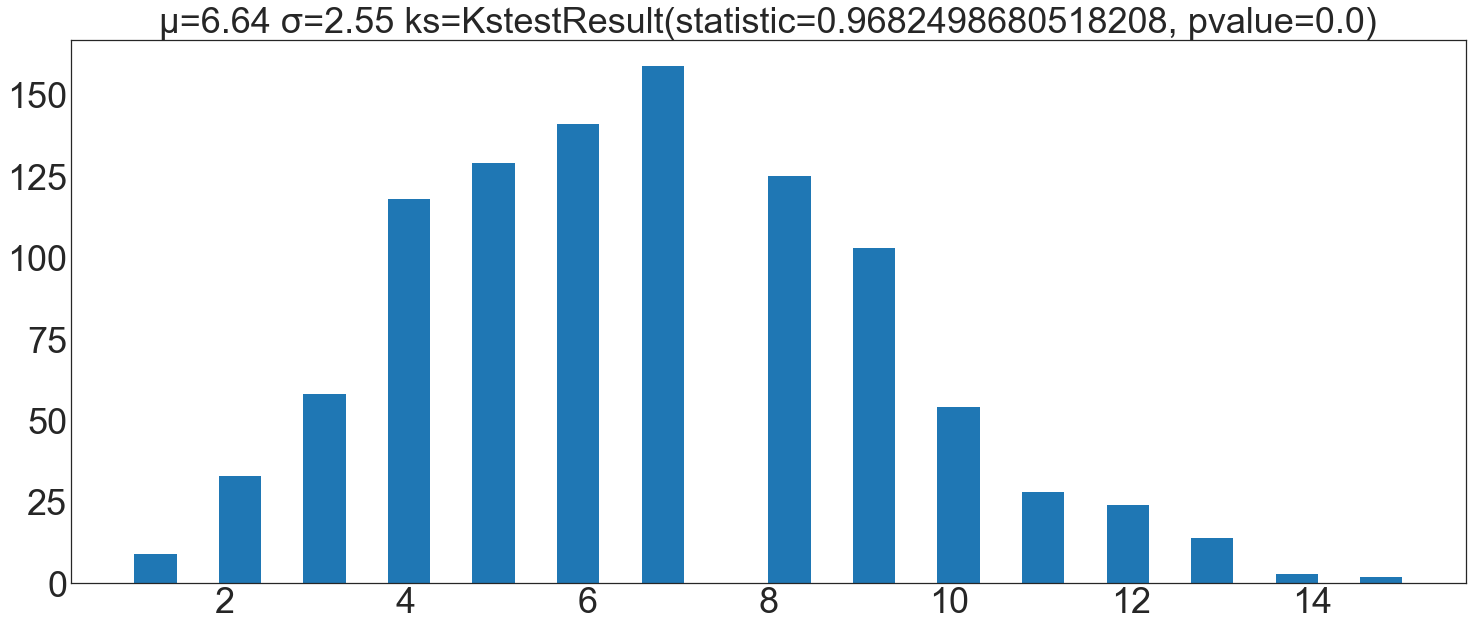

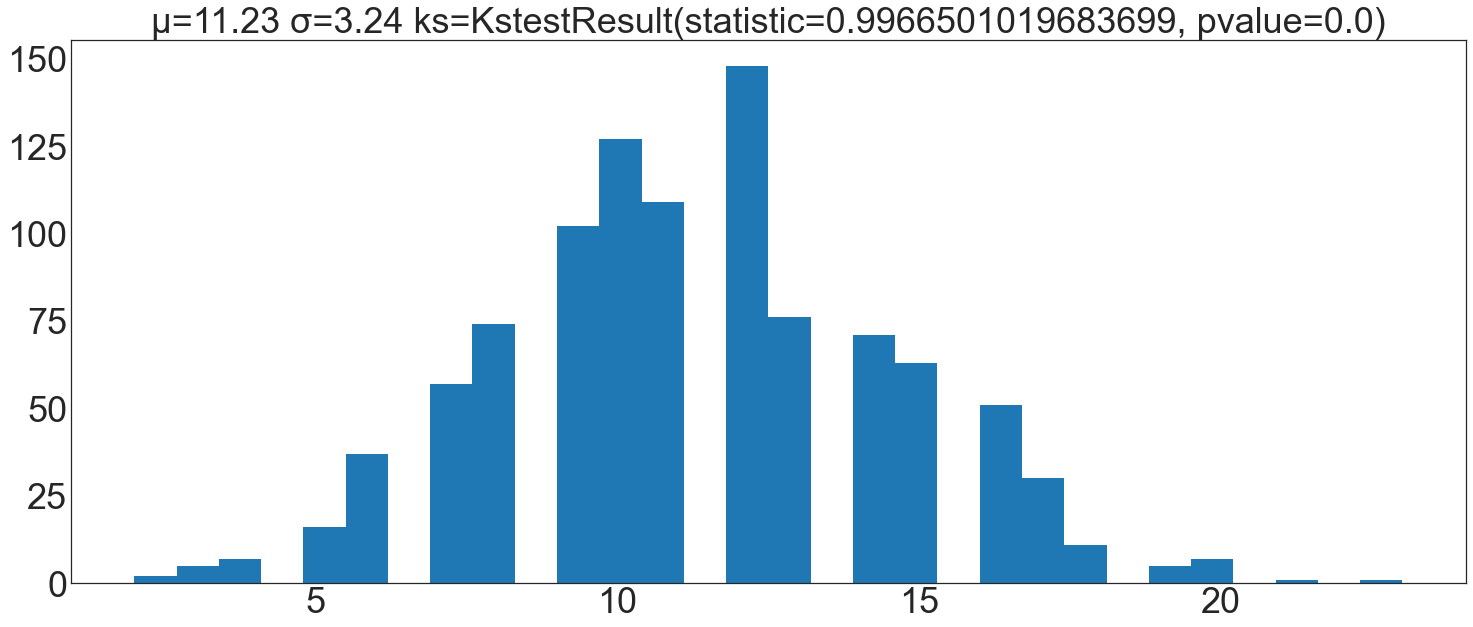

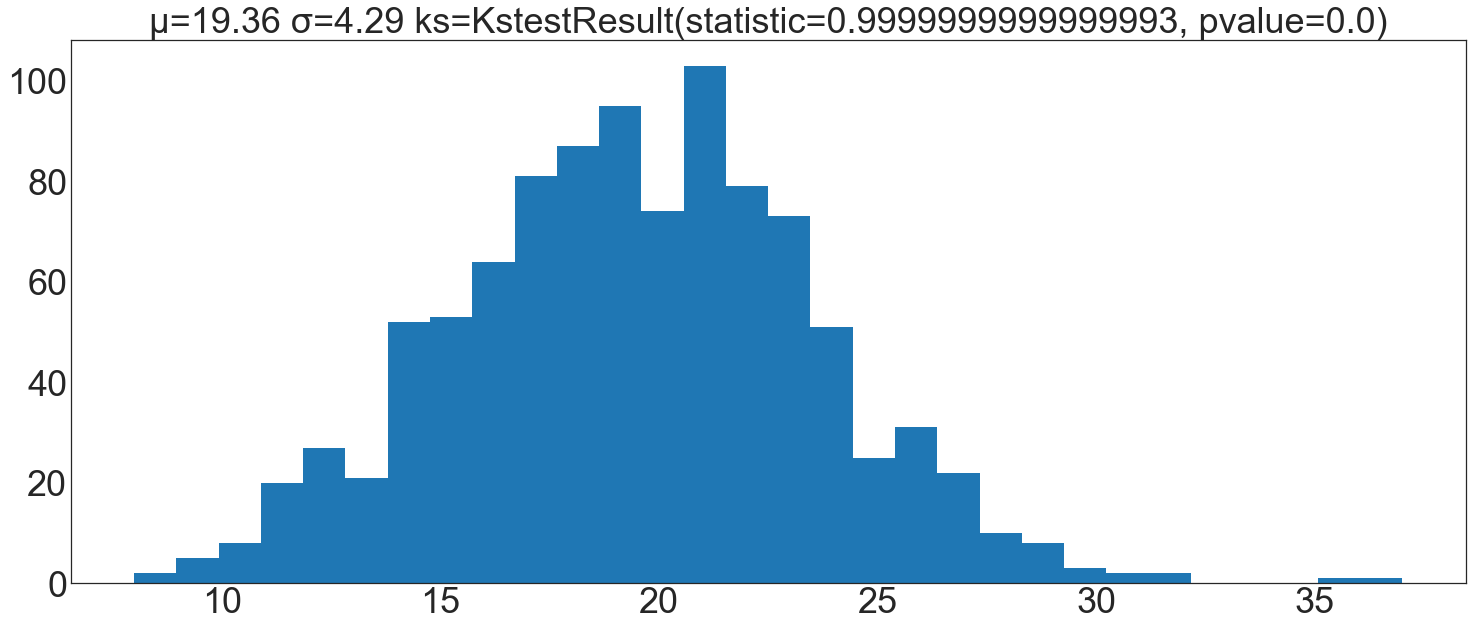

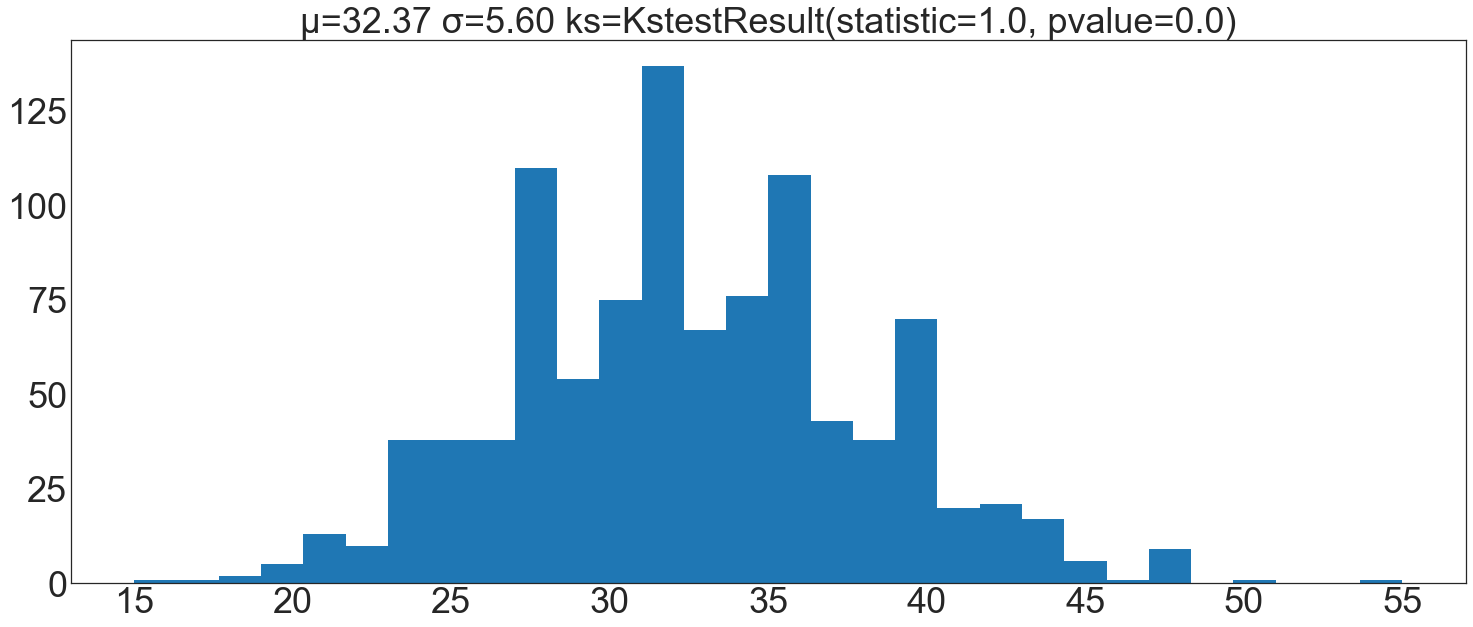

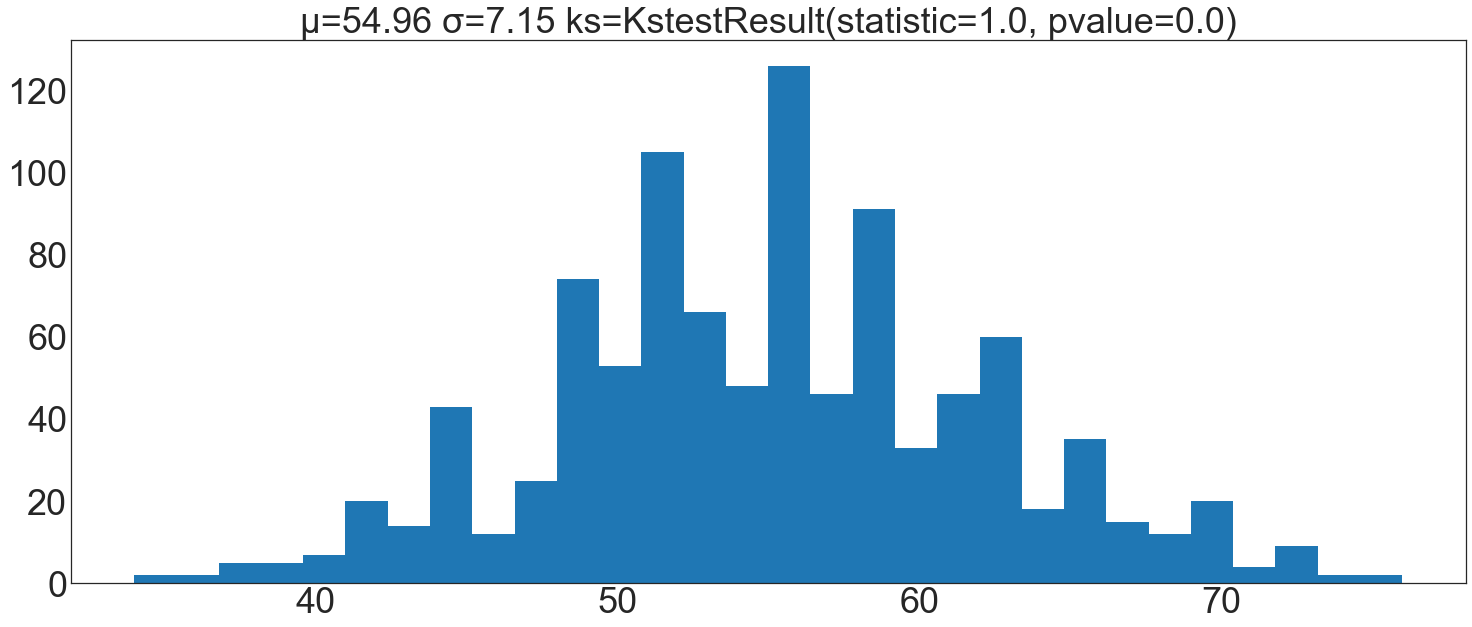

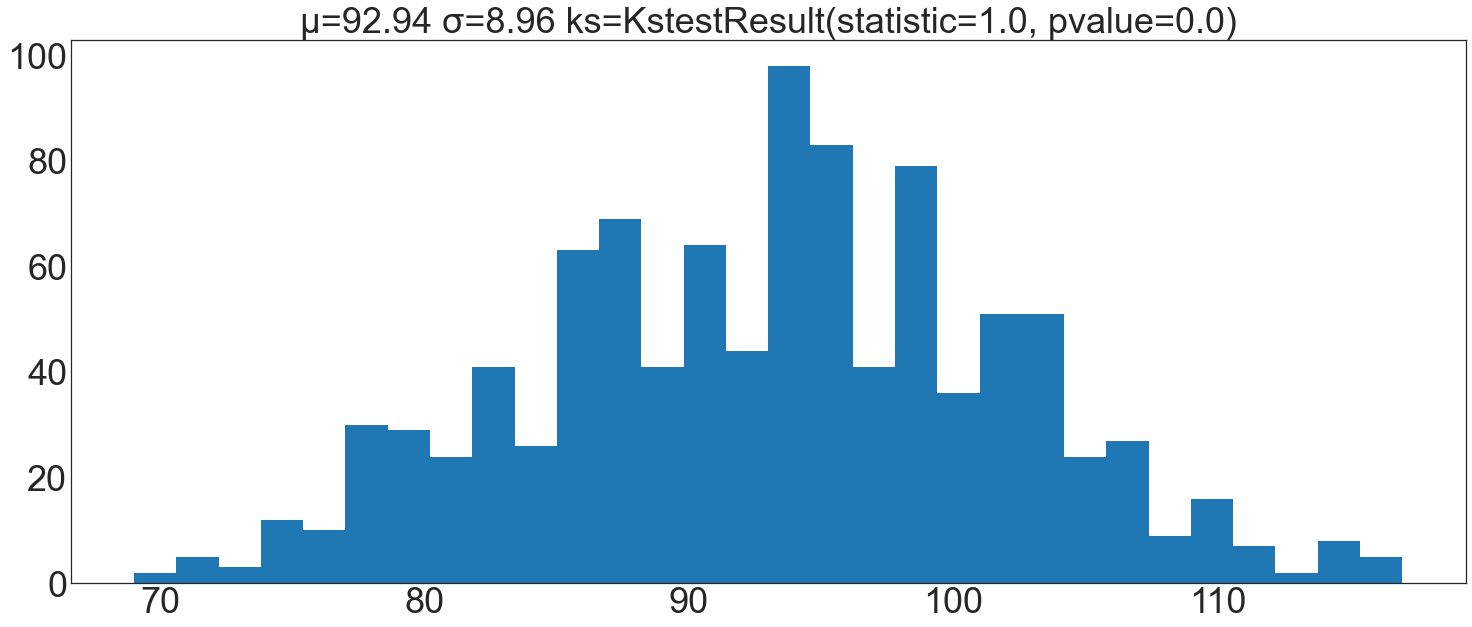

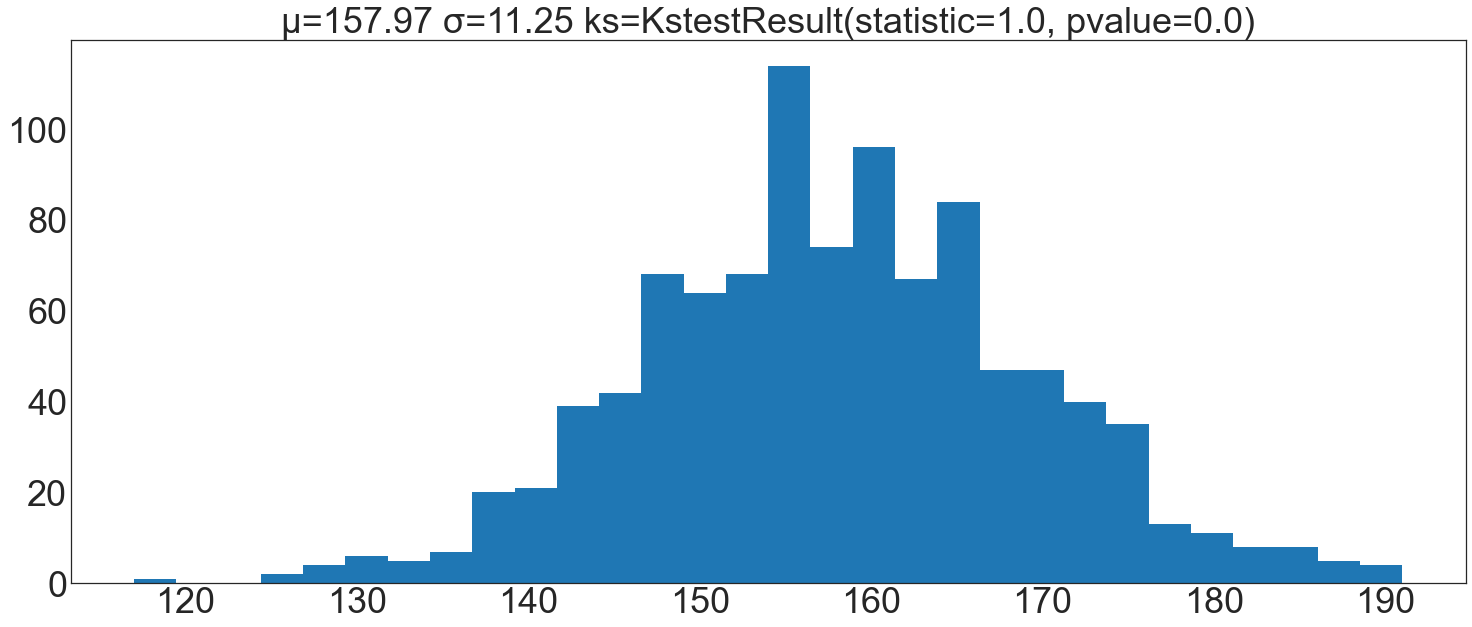

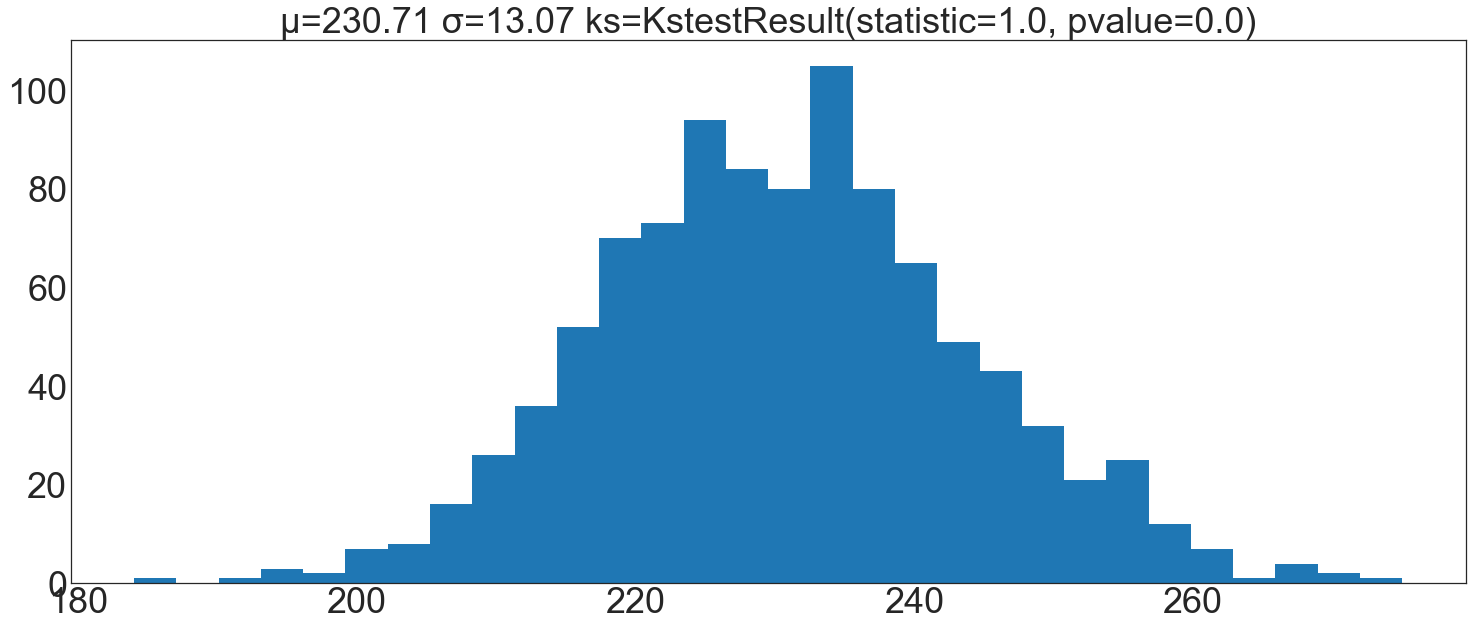

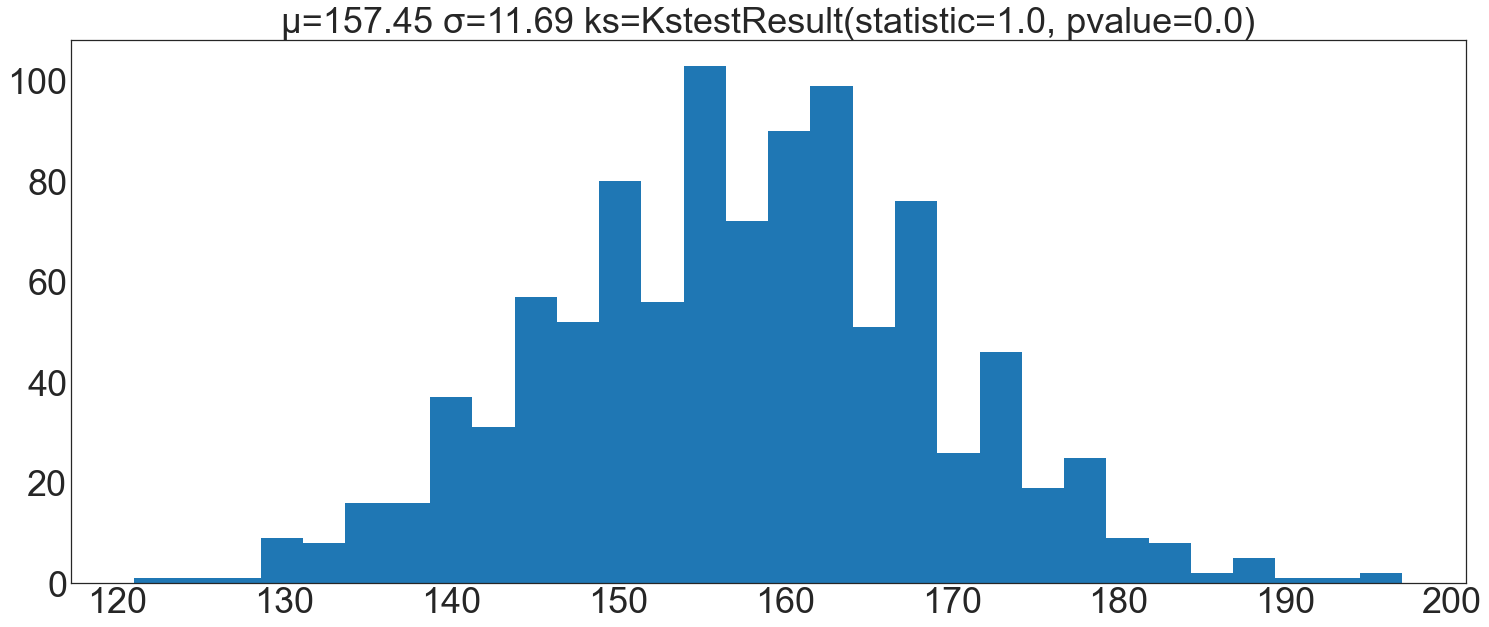

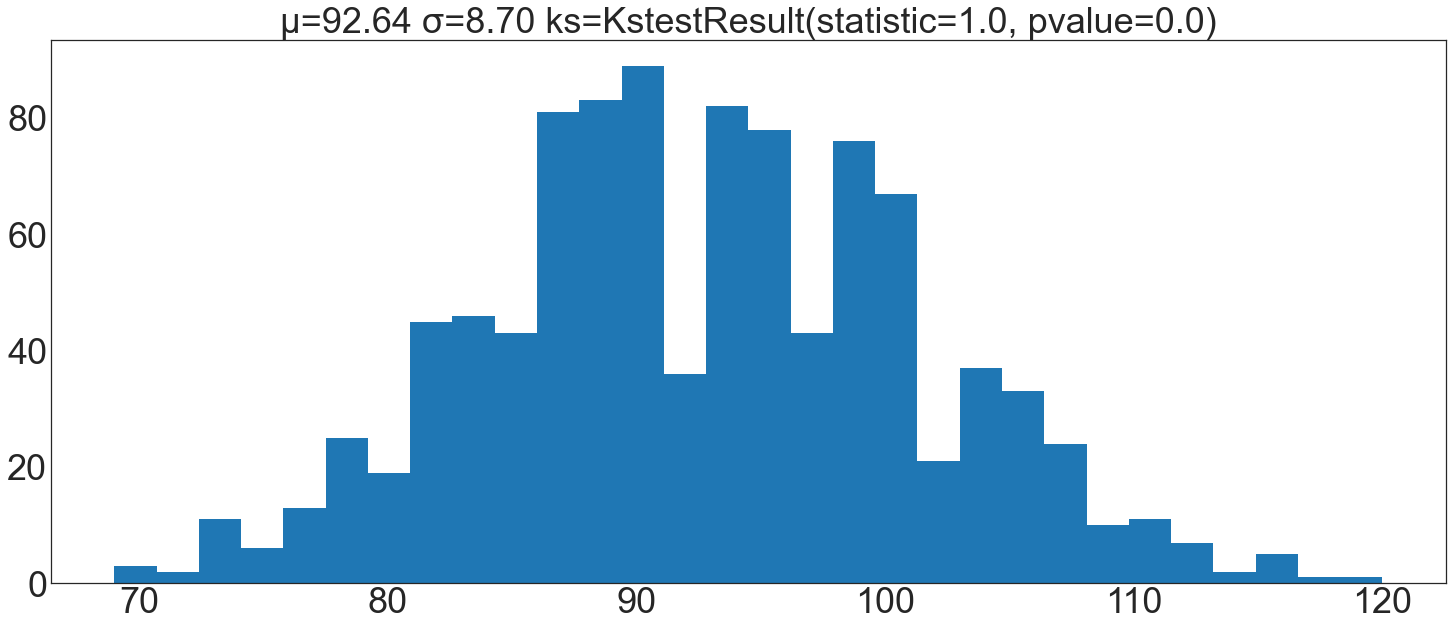

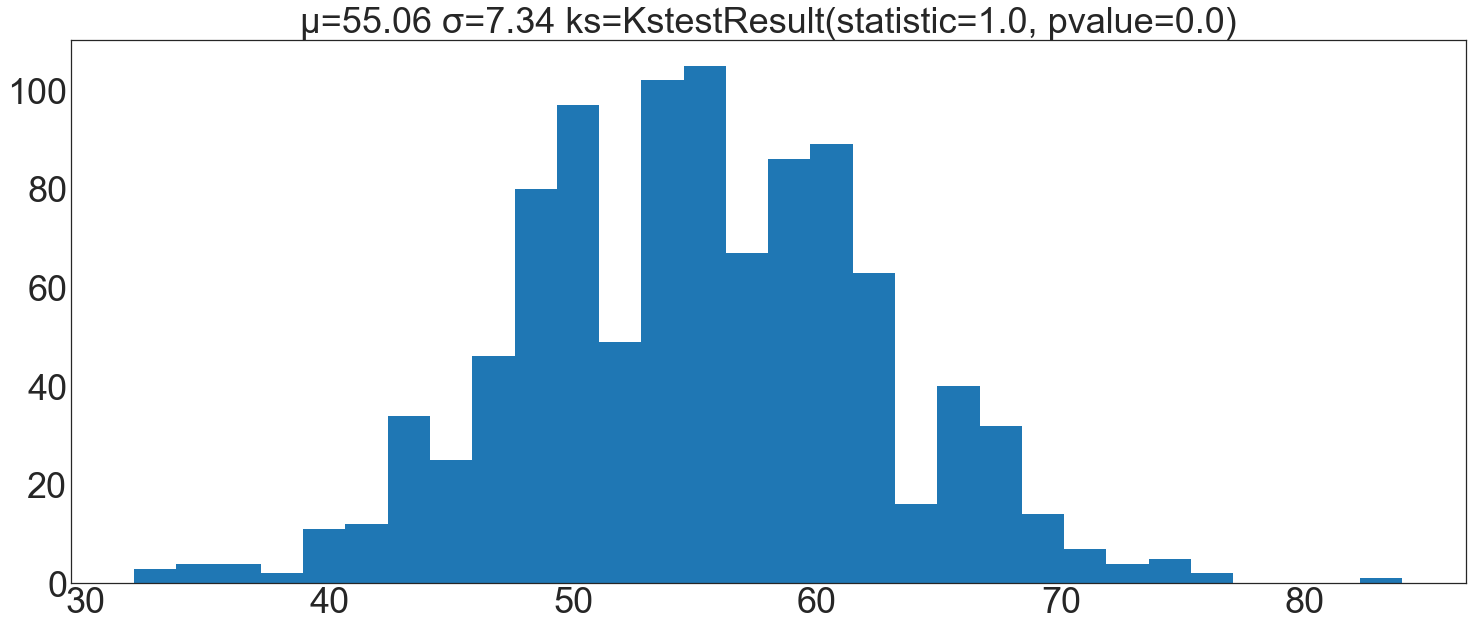

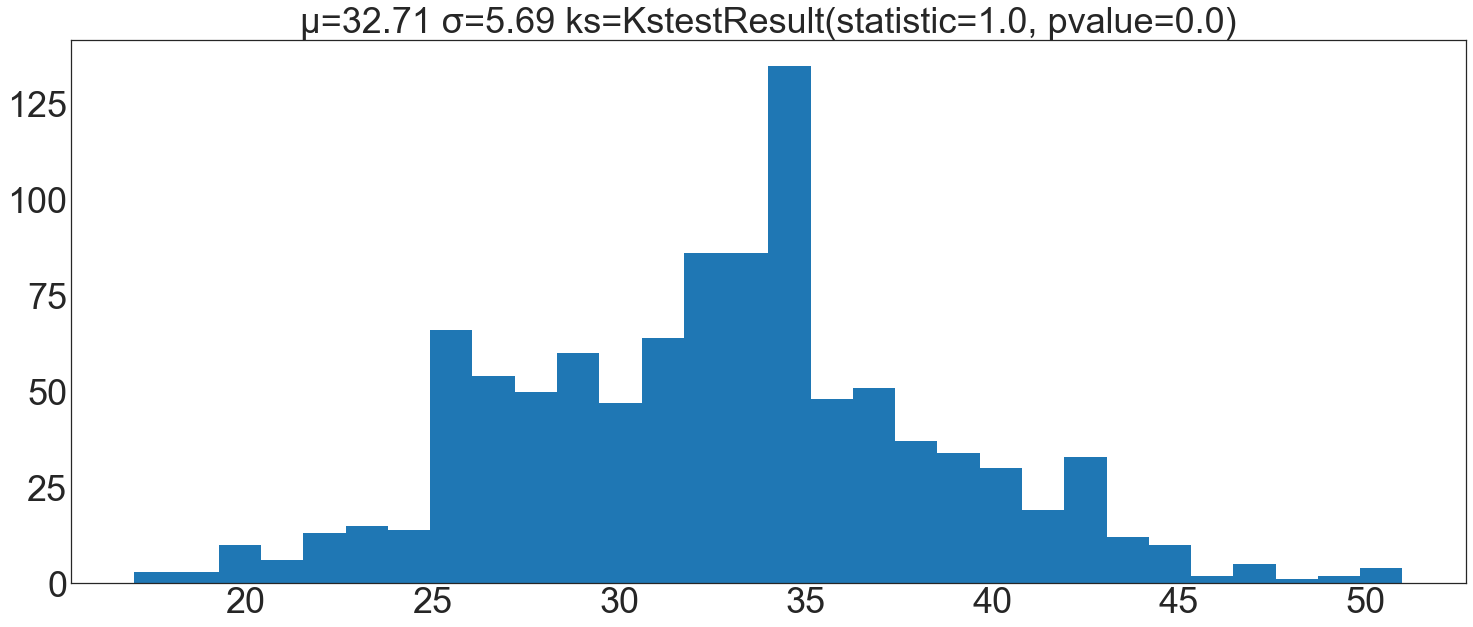

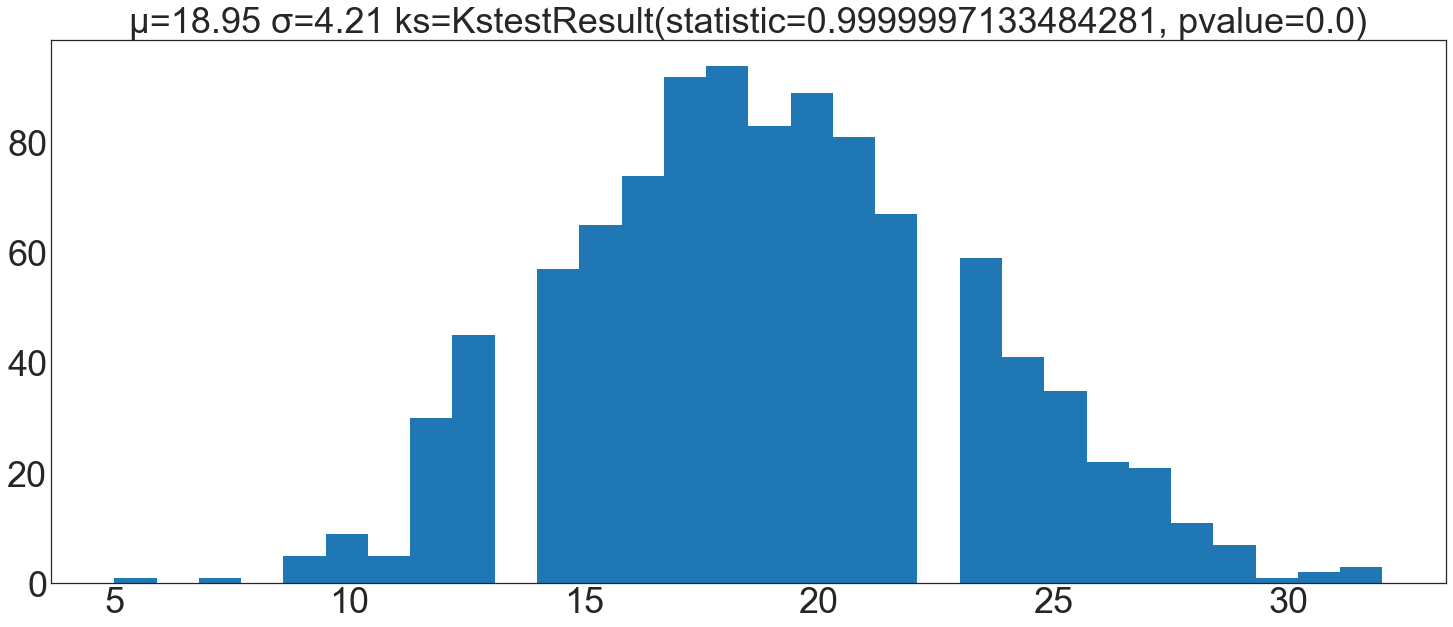

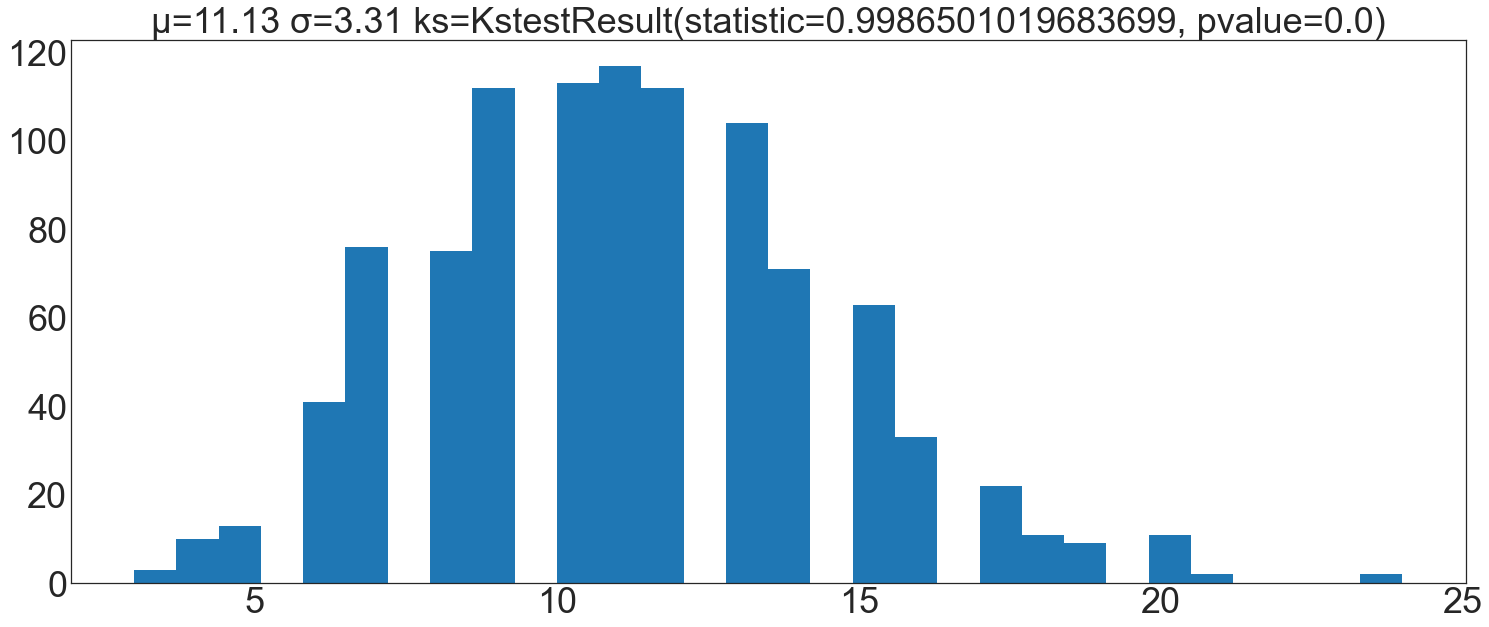

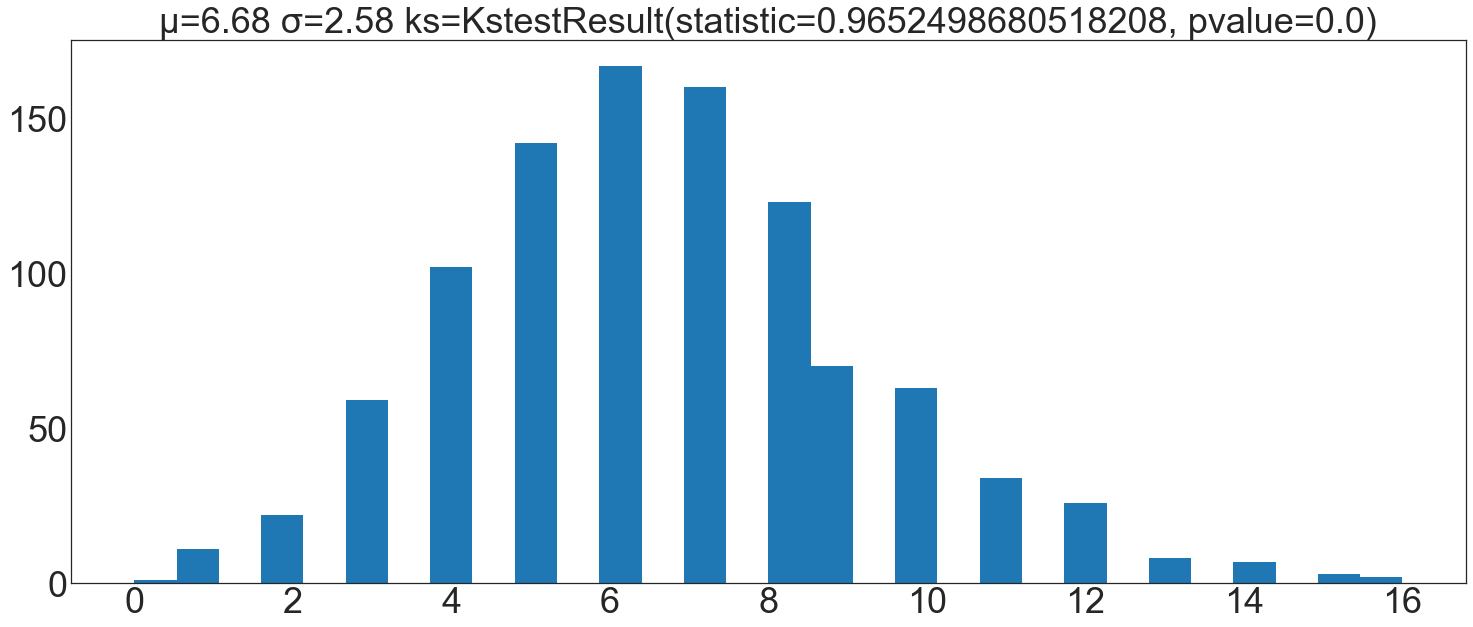

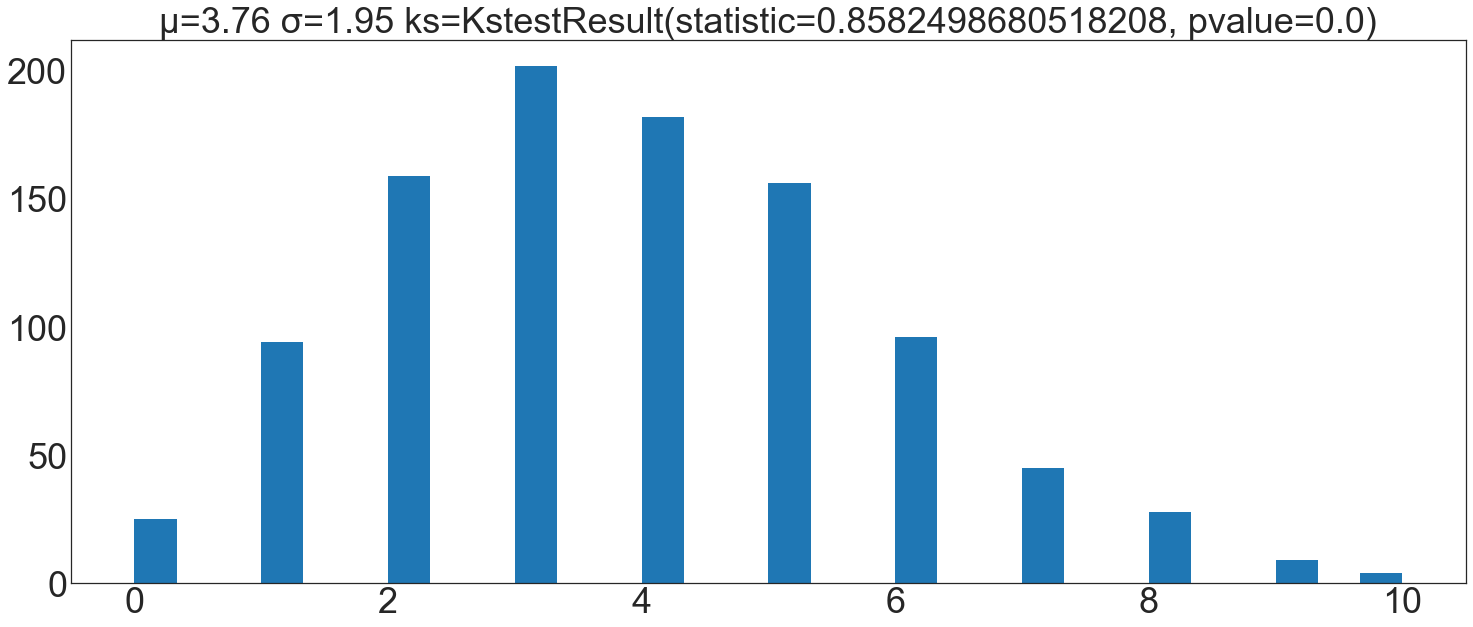

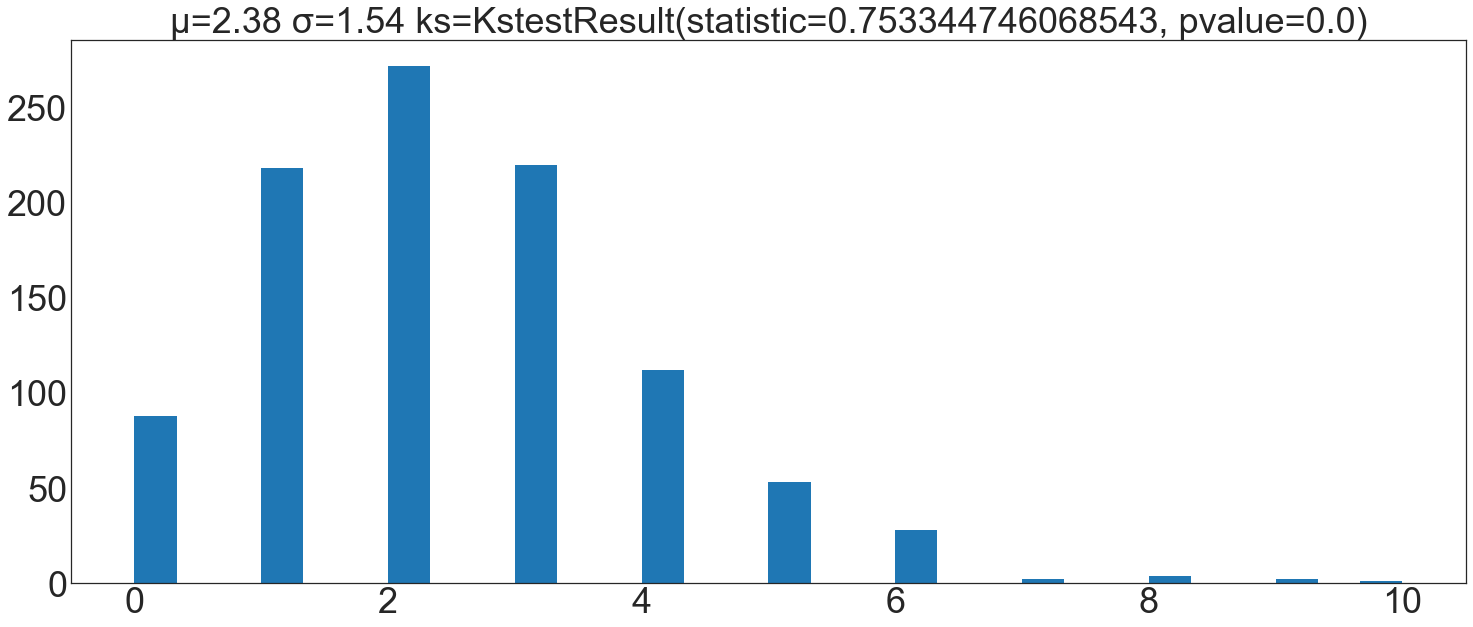

In [16]:
op = PrivateClampedSum(lower_bound=0, upper_bound=1)
results = None
bins = np.linspace(-5, 5, num=20)

for b in range(1000):
    trials = np.random.laplace(0, 1, size=1000)
    
    binned, _ = np.histogram(trials, bins=bins)
    
    if results is None:
        results = np.array([binned])
    else:
        results = np.concatenate((results, np.array([binned])))
    
results = np.transpose(results)

plt.hist(np.random.laplace(0, 1, size=1000), bins=30)
plt.title("Single sample")
plt.show()

for x in range(len(results)):
    fit = stats.kstest(results[x], 'norm')
    plt.hist(results[x], bins=30)
    plt.title(f"μ={np.mean(results[x]):.2f} σ={np.std(results[x]):.2f} ks={fit}")
    plt.show()

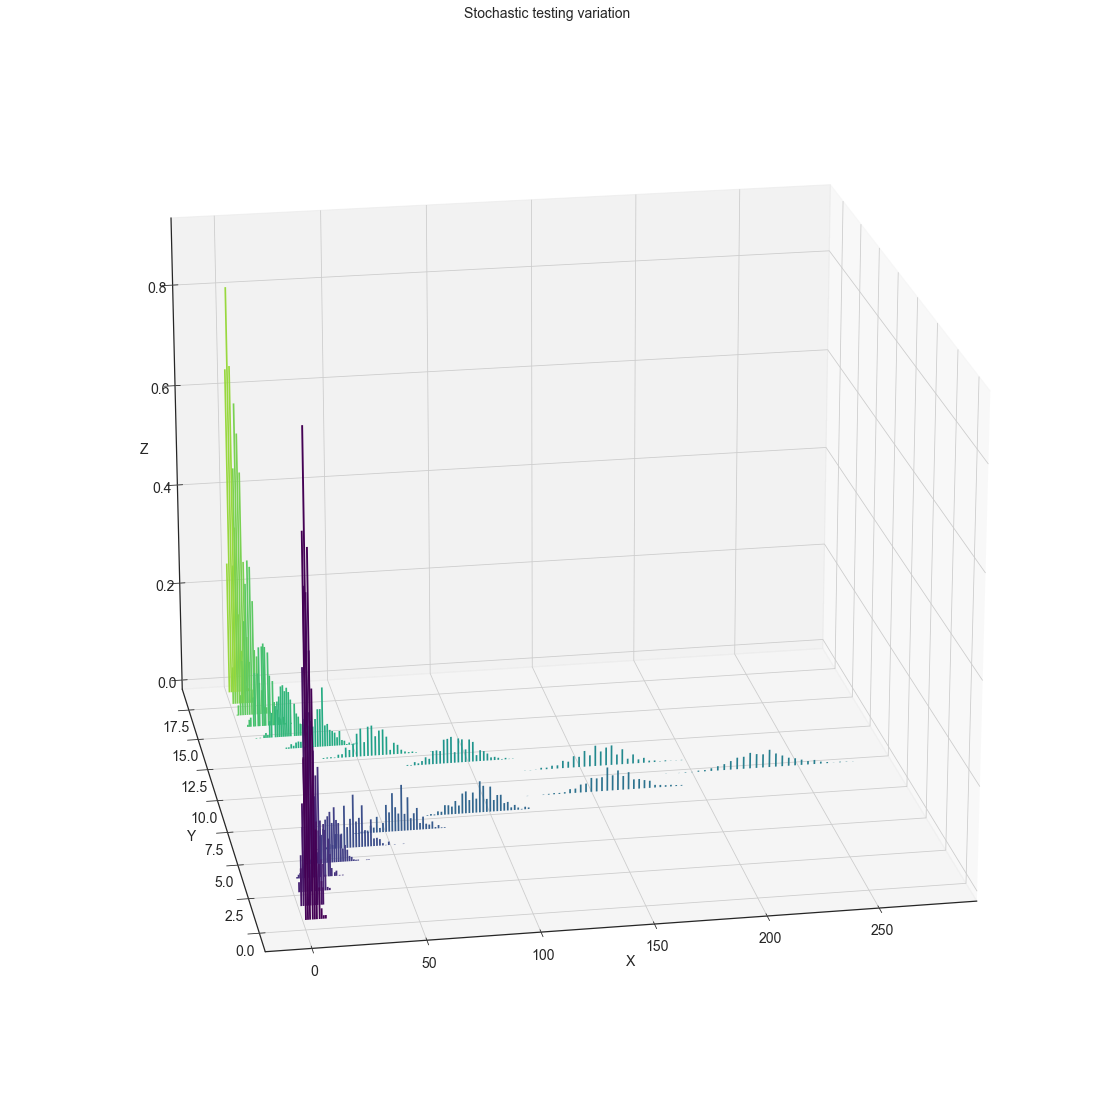

In [77]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(25, 15))
ax = Axes3D(fig)
ax.view_init(elev=20, azim=260)

cmap = plt.get_cmap('viridis')

for z in range(len(results)):
    counts, bin_edges = np.histogram(results[z], bins=30, density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    xs = bin_centers
    ys = counts

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.

    color = cmap.colors[z * 12]

    ax.bar(xs, ys, zs=z, zdir='y', color=color, alpha=1)

plt.title("Stochastic testing variation")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# ax.set_xlim3d(0, 500)

plt.show()


## Approach to Stochastic Test with Confidence Intervals ##

* Run trial multiple times
* Compute stddev of each bin
* Use stddev to compute 90% CI
* Compute ε at upper and lower of 90% CI
